<a href="https://colab.research.google.com/github/diegonzalez87/Brotes-de-Dengue-usando-Inteligencia-Artificial_1/blob/main/NOTEBOOK_01_AN%C3%81LISIS_EXPLORATORIO_DE_DATOS_EPIDEMIOL%C3%93GICOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

============================================================================

NOTEBOOK 01: ANÁLISIS EXPLORATORIO DE DATOS EPIDEMIOLÓGICOS

TFM: Detección de Brotes de Dengue usando IA - Cauca, Colombia

Autor: Diego Alejandto González Acuña

Fecha: 2025

============================================================================


Este notebook realiza el análisis exploratorio exhaustivo de los datos
epidemiológicos de dengue (cases_clean.csv) correspondientes al período
2016-2018 en tres municipios del Cauca: Piamonte, Patía y Miranda.

Objetivos:
1. Caracterizar la distribución temporal de casos
2. Identificar patrones espaciales y hotspots
3. Analizar perfil demográfico de casos
4. Evaluar calidad y completitud de datos
5. Generar visualizaciones para el Capítulo 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from datetime import datetime
from scipy import stats
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [ ]:
# ============================================================================
# 2. CARGA DE DATOS
# ============================================================================

# Ruta del dataset
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/cases_clean.csv'

# Cargar datos
df_casos = pd.read_csv(DATA_PATH)

print(f"\n{'='*80}")
print(f"DATASET CARGADO: cases_clean.csv")
print(f"{'='*80}")
print(f"Filas: {df_casos.shape[0]:,}")
print(f"Columnas: {df_casos.shape[1]}")
print(f"\nPrimeras 5 filas:")
print(df_casos.head())


DATASET CARGADO: cases_clean.csv
Filas: 573
Columnas: 15

Primeras 5 filas:
   OBJECTID          Loc_name   Longitud   Latitud           Proceso  \
0       117            La Paz -76.329537  1.119479  Georreferenciado   
1       114  Vereda Trojayaco -76.273166  0.984080  Georreferenciado   
2       123  Villa Los Prados -76.327719  1.119409  Georreferenciado   
3       116            La Paz -76.329537  1.119479  Georreferenciado   
4       133  Villa Los Prados -76.327719  1.119409  Georreferenciado   

                  Match_addr        Barrio_OSM Sexo  Edad  Ocupación   \
0          Nombre del Barrio            La Paz    M    11        9999   
1  Nombre del Centro Poblado         Trojayaco    M    40        6112   
2          Nombre del Barrio  Villa Los Prados    M     4        9999   
3          Nombre del Barrio            La Paz    F    14        9999   
4          Nombre del Barrio  Villa Los Prados    M     7        9999   

   Pertenencia etnica         fec_consulta         

In [ ]:
# ============================================================================
# 3. EXPLORACIÓN INICIAL Y CALIDAD DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("INFORMACIÓN DEL DATASET")
print(f"{'='*80}")
print(df_casos.info())

print(f"\n{'='*80}")
print("ESTADÍSTICAS DESCRIPTIVAS")
print(f"{'='*80}")
print(df_casos.describe())

# Verificar valores faltantes
print(f"\n{'='*80}")
print("VALORES FALTANTES")
print(f"{'='*80}")
missing = df_casos.isnull().sum()
missing_pct = (missing / len(df_casos)) * 100
missing_df = pd.DataFrame({
    'Columna': missing.index,
    'Valores Faltantes': missing.values,
    'Porcentaje (%)': missing_pct.values
})
print(missing_df[missing_df['Valores Faltantes'] > 0])

if missing_df['Valores Faltantes'].sum() == 0:
    print("✓ No hay valores faltantes en el dataset")


INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            573 non-null    int64  
 1   Loc_name            573 non-null    object 
 2   Longitud            573 non-null    float64
 3   Latitud             573 non-null    float64
 4   Proceso             573 non-null    object 
 5   Match_addr          573 non-null    object 
 6   Barrio_OSM          573 non-null    object 
 7   Sexo                573 non-null    object 
 8   Edad                573 non-null    int64  
 9   Ocupación           573 non-null    int64  
 10  Pertenencia etnica  573 non-null    int64  
 11  fec_consulta        573 non-null    object 
 12  ini_sintomas        573 non-null    object 
 13  locationID          573 non-null    object 
 14  county              573 non-null    object 
dtypes: float64(2), int64(4), object(

In [ ]:
# ============================================================================
# 4. PREPROCESAMIENTO DE FECHAS
# ============================================================================

print(f"\n{'='*80}")
print("PREPROCESAMIENTO DE FECHAS")
print(f"{'='*80}")

# Convertir columnas de fecha a datetime
df_casos['fec_consulta'] = pd.to_datetime(df_casos['fec_consulta'], errors='coerce')
df_casos['ini_sintomas'] = pd.to_datetime(df_casos['ini_sintomas'], errors='coerce')

# Extraer componentes temporales
df_casos['año'] = df_casos['fec_consulta'].dt.year
df_casos['mes'] = df_casos['fec_consulta'].dt.month
df_casos['semana'] = df_casos['fec_consulta'].dt.isocalendar().week
df_casos['dia_año'] = df_casos['fec_consulta'].dt.dayofyear
df_casos['mes_nombre'] = df_casos['fec_consulta'].dt.month_name()

print(f"Rango temporal: {df_casos['fec_consulta'].min().date()} a {df_casos['fec_consulta'].max().date()}")
print(f"Años únicos: {sorted(df_casos['año'].unique())}")



PREPROCESAMIENTO DE FECHAS
Rango temporal: 2015-01-05 a 2022-01-01
Años únicos: [np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(nan), np.float64(2022.0)]



ANÁLISIS DE DISTRIBUCIÓN TEMPORAL

Tabla 4.1: Distribución de Casos por Año
   año  casos  porcentaje
2015.0    108        18.9
2016.0    107        18.7
2017.0     18         3.1
2018.0     73        12.8
2019.0     87        15.2
2020.0    121        21.2
2021.0     57        10.0
2022.0      1         0.2


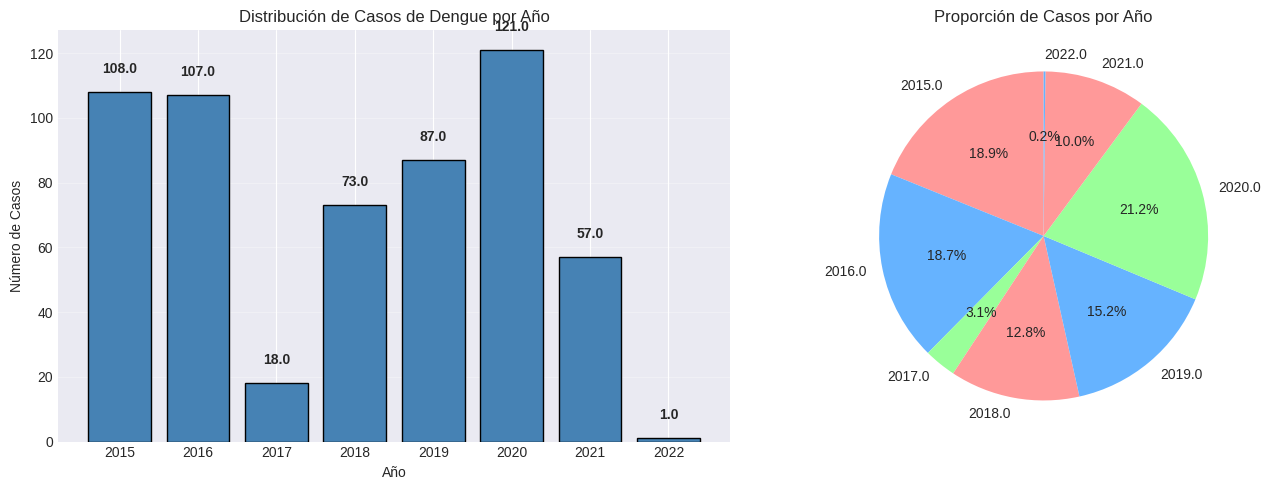



Distribución Mensual (Agregada):
mes_nombre  casos
       Ene     76
       Feb     96
       Mar     52
       Abr     60
       May     60
       Jun     40
       Jul     29
       Ago     16
       Sep     21
       Oct     24
       Nov     39
       Dic     59


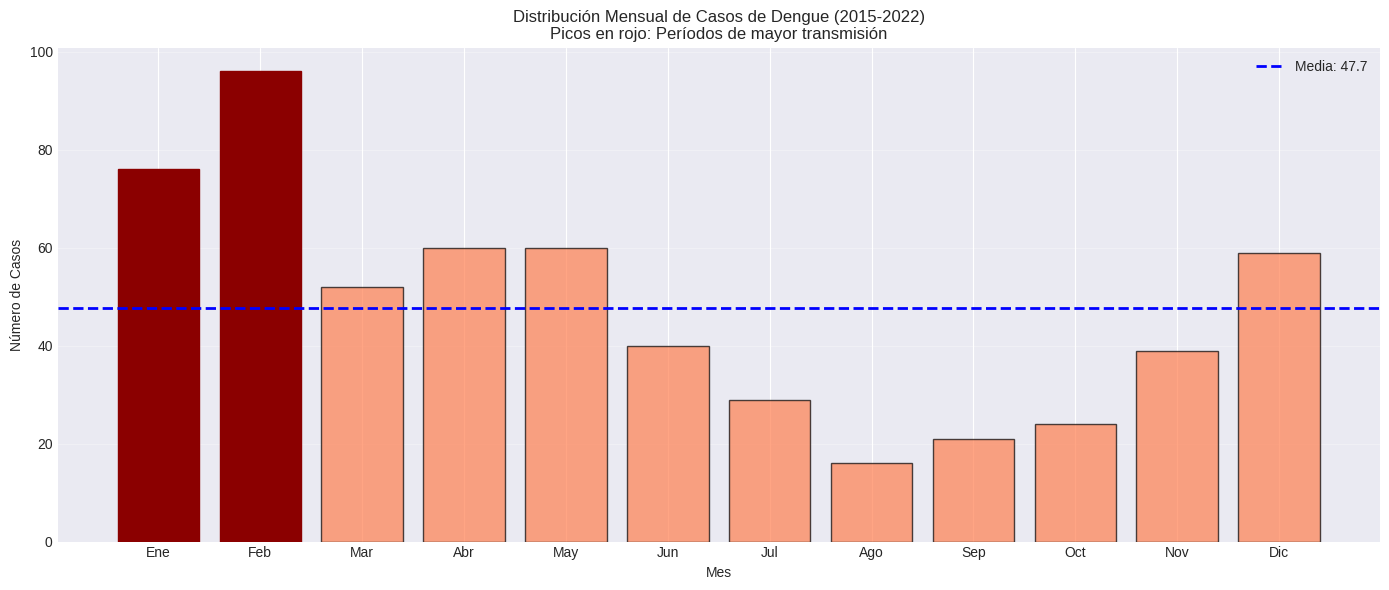

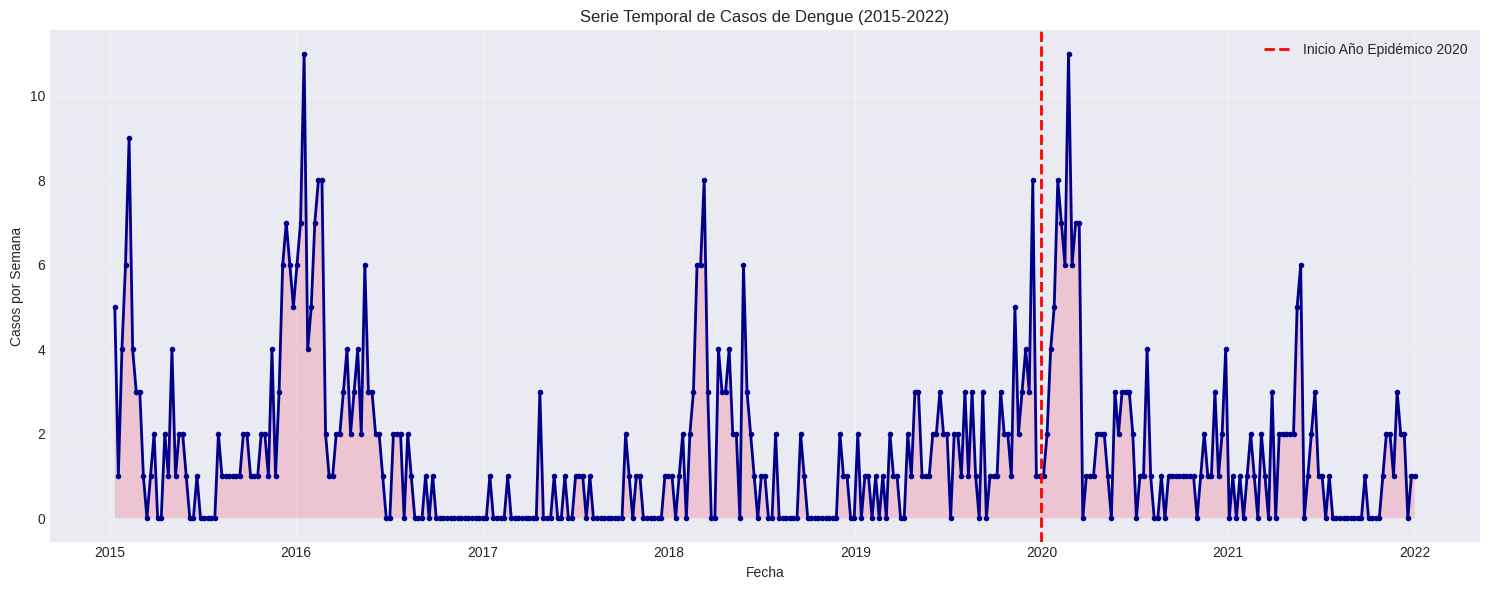

In [ ]:
# ============================================================================
# 5. ANÁLISIS TEMPORAL
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DISTRIBUCIÓN TEMPORAL")
print(f"{'='*80}")

# Casos por año
casos_año = df_casos.groupby('año').size().reset_index(name='casos')
casos_año['porcentaje'] = (casos_año['casos'] / casos_año['casos'].sum() * 100).round(1)

print("\nTabla 4.1: Distribución de Casos por Año")
print(casos_año.to_string(index=False))

# Visualización: Casos por año
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(casos_año['año'], casos_año['casos'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Número de Casos')
axes[0].set_title('Distribución de Casos de Dengue por Año')
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for idx, row in casos_año.iterrows():
    axes[0].text(row['año'], row['casos'] + 5, str(row['casos']),
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pie
axes[1].pie(casos_año['casos'], labels=casos_año['año'], autopct='%1.1f%%',
           startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
axes[1].set_title('Proporción de Casos por Año')

plt.tight_layout()
plt.savefig('fig_4_1_casos_por_año.png', dpi=300, bbox_inches='tight')
plt.show()

# Casos por mes (agregado todos los años)
casos_mes = df_casos.groupby('mes').size().reset_index(name='casos')
meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
casos_mes['mes_nombre'] = casos_mes['mes'].astype(int).map(lambda x: meses_nombres[x-1])

print("\n\nDistribución Mensual (Agregada):")
print(casos_mes[['mes_nombre', 'casos']].to_string(index=False))

# Visualización: Casos por mes
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(casos_mes['mes_nombre'], casos_mes['casos'],
              color='coral', edgecolor='black', alpha=0.7)

# Resaltar picos estacionales
pico_primario = casos_mes.nlargest(2, 'casos')['mes'].values
for bar, mes in zip(bars, casos_mes['mes']):
    if mes in pico_primario:
        bar.set_color('darkred')
        bar.set_alpha(1.0)

ax.set_xlabel('Mes')
ax.set_ylabel('Número de Casos')
ax.set_title('Distribución Mensual de Casos de Dengue (2015-2022)\nPicos en rojo: Períodos de mayor transmisión')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=casos_mes['casos'].mean(), color='blue', linestyle='--',
           label=f'Media: {casos_mes["casos"].mean():.1f}', linewidth=2)
ax.legend()

plt.tight_layout()
plt.savefig('fig_4_2_casos_por_mes.png', dpi=300, bbox_inches='tight')
plt.show()

# Serie temporal completa
serie_temporal = df_casos.groupby('fec_consulta').size().reset_index(name='casos')
serie_temporal = serie_temporal.set_index('fec_consulta').resample('W').sum()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(serie_temporal.index, serie_temporal['casos'],
        linewidth=2, color='darkblue', marker='o', markersize=3)
ax.fill_between(serie_temporal.index, serie_temporal['casos'], alpha=0.3)
ax.set_xlabel('Fecha')
ax.set_ylabel('Casos por Semana')
ax.set_title('Serie Temporal de Casos de Dengue (2015-2022)')
ax.grid(True, alpha=0.3)
ax.axvline(pd.to_datetime('2020-01-01'), color='red', linestyle='--',
           label='Inicio Año Epidémico 2020', linewidth=2)
ax.legend()

plt.tight_layout()
plt.savefig('fig_4_3_serie_temporal.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISIS DE DISTRIBUCIÓN ESPACIAL

Tabla 4.2: Distribución de Casos por Municipio
  county  casos  porcentaje  poblacion  incidencia_x10k
 Miranda    175        30.5      42000             41.7
   Patía    208        36.3      35200             59.1
Piamonte    190        33.2      18500            102.7


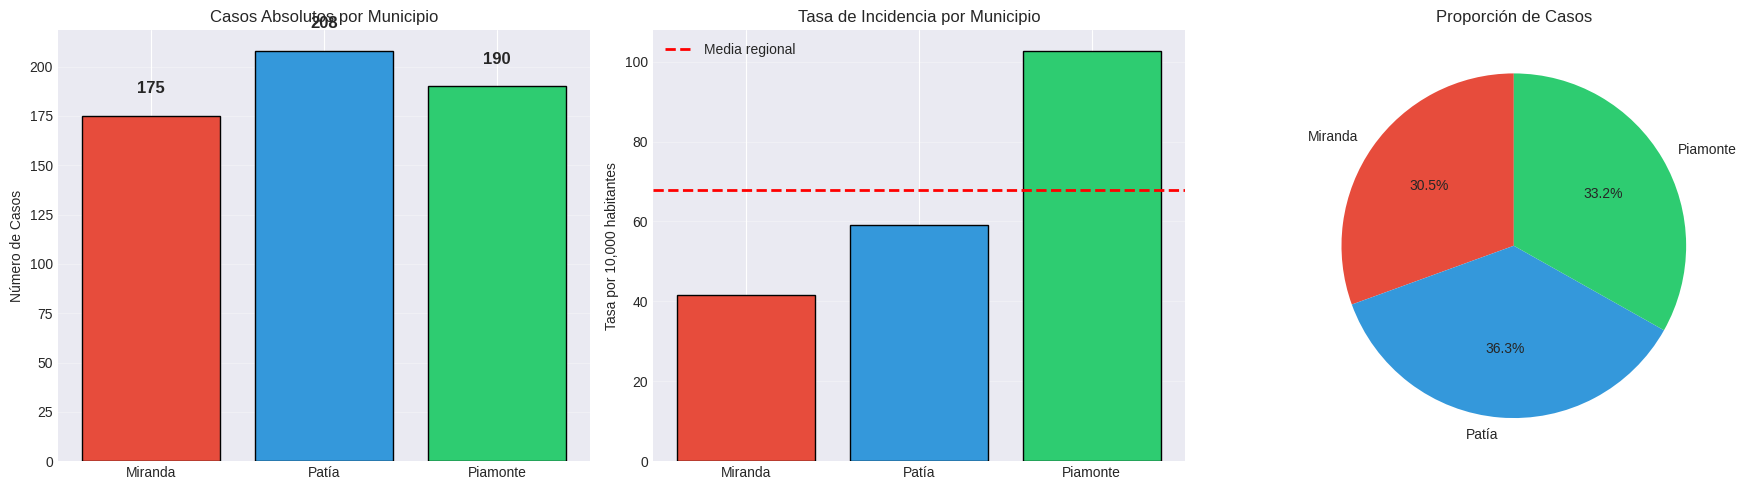


CLUSTERING ESPACIAL (DBSCAN)
Número de clusters identificados: 7
Casos sin cluster (ruido): 43

Top 8 Clusters por Número de Casos:
 Cluster  Num_Casos  Lat_Centro  Lon_Centro Municipio_Dominante
       5        175    3.253292  -76.229484             Miranda
       0        170    1.117919  -76.326823            Piamonte
       3        157    2.114092  -76.982582               Patía
       2         15    1.966927  -77.118740               Patía
       4          7    2.170618  -76.899911               Patía
       1          6    1.171722  -76.319376            Piamonte


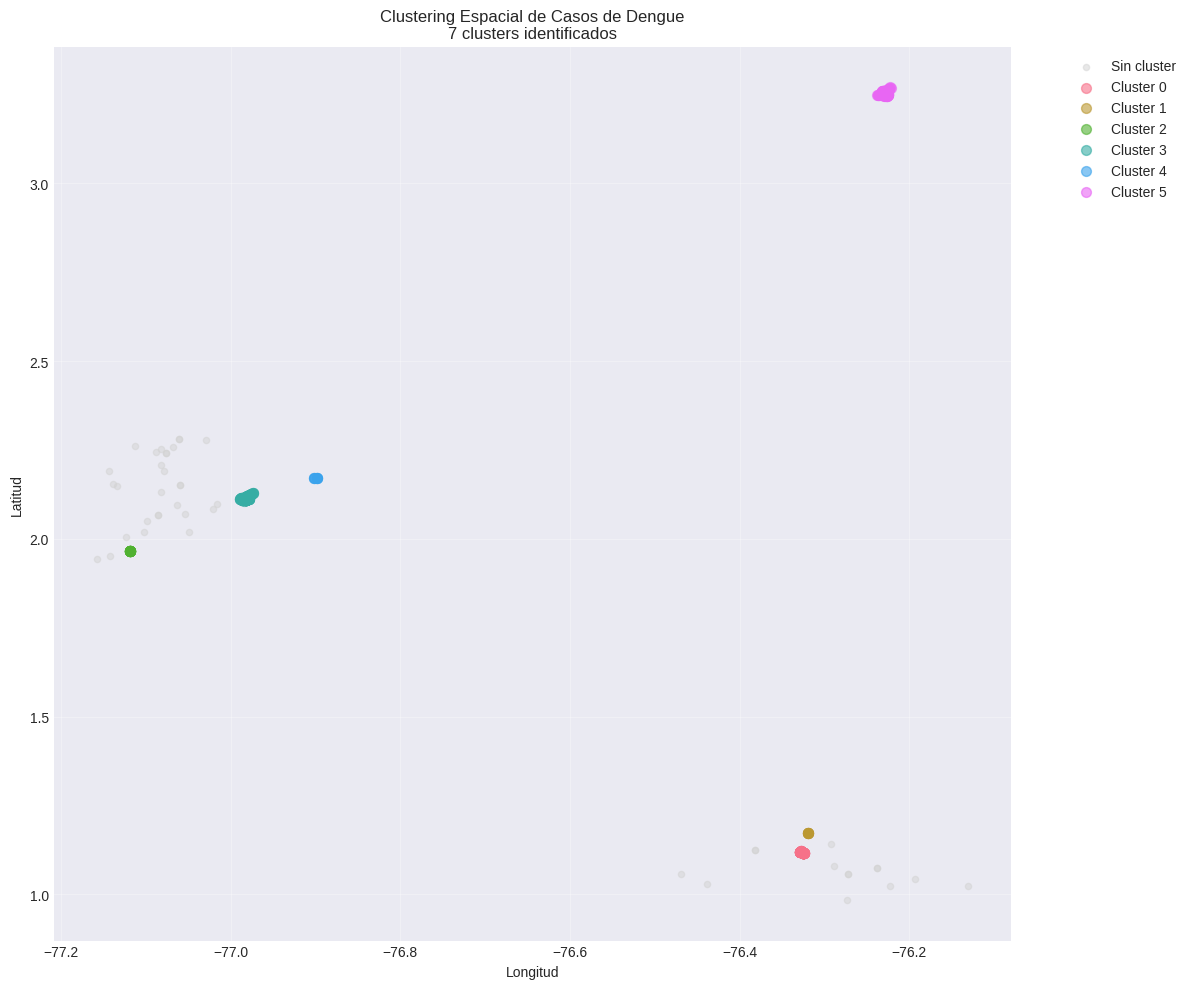

In [ ]:
# ============================================================================
# 6. ANÁLISIS ESPACIAL
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DISTRIBUCIÓN ESPACIAL")
print(f"{'='*80}")

# Casos por municipio
casos_municipio = df_casos.groupby('county').size().reset_index(name='casos')
casos_municipio['porcentaje'] = (casos_municipio['casos'] / casos_municipio['casos'].sum() * 100).round(1)

# Poblaciones estimadas (datos aproximados)
poblaciones = {
    'Piamonte': 18500,
    'Patía': 35200,
    'Miranda': 42000
}
casos_municipio['poblacion'] = casos_municipio['county'].map(poblaciones)
casos_municipio['incidencia_x10k'] = (casos_municipio['casos'] / casos_municipio['poblacion'] * 10000).round(1)

print("\nTabla 4.2: Distribución de Casos por Municipio")
print(casos_municipio.to_string(index=False))

# Visualización: Casos por municipio
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Número absoluto de casos
axes[0].bar(casos_municipio['county'], casos_municipio['casos'],
           color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')
axes[0].set_ylabel('Número de Casos')
axes[0].set_title('Casos Absolutos por Municipio')
axes[0].grid(axis='y', alpha=0.3)
for i, row in casos_municipio.iterrows():
    axes[0].text(i, row['casos'] + 10, str(row['casos']),
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# Gráfico 2: Tasa de incidencia
axes[1].bar(casos_municipio['county'], casos_municipio['incidencia_x10k'],
           color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')
axes[1].set_ylabel('Tasa por 10,000 habitantes')
axes[1].set_title('Tasa de Incidencia por Municipio')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=casos_municipio['incidencia_x10k'].mean(),
               color='red', linestyle='--', label='Media regional', linewidth=2)
axes[1].legend()

# Gráfico 3: Distribución porcentual
axes[2].pie(casos_municipio['casos'], labels=casos_municipio['county'],
           autopct='%1.1f%%', startangle=90,
           colors=['#e74c3c', '#3498db', '#2ecc71'])
axes[2].set_title('Proporción de Casos')

plt.tight_layout()
plt.savefig('fig_4_4_casos_por_municipio.png', dpi=300, bbox_inches='tight')
plt.show()

# Clustering espacial con DBSCAN
print(f"\n{'='*80}")
print("CLUSTERING ESPACIAL (DBSCAN)")
print(f"{'='*80}")

# Extraer coordenadas
coords = df_casos[['Latitud', 'Longitud']].values

# Aplicar DBSCAN
# eps=0.01 grados ≈ 1.1 km, min_samples=5 casos mínimos por cluster
dbscan = DBSCAN(eps=0.01, min_samples=5)
df_casos['cluster'] = dbscan.fit_predict(coords)

# Estadísticas de clusters
n_clusters = len(set(df_casos['cluster'])) - (1 if -1 in df_casos['cluster'] else 0)
n_noise = list(df_casos['cluster']).count(-1)

print(f"Número de clusters identificados: {n_clusters}")
print(f"Casos sin cluster (ruido): {n_noise}")

# Análisis de clusters
if n_clusters > 0:
    cluster_stats = df_casos[df_casos['cluster'] != -1].groupby('cluster').agg({
        'OBJECTID': 'count',
        'Latitud': 'mean',
        'Longitud': 'mean',
        'county': lambda x: x.mode()[0]
    }).reset_index()
    cluster_stats.columns = ['Cluster', 'Num_Casos', 'Lat_Centro', 'Lon_Centro', 'Municipio_Dominante']
    cluster_stats = cluster_stats.sort_values('Num_Casos', ascending=False)

    print("\nTop 8 Clusters por Número de Casos:")
    print(cluster_stats.head(8).to_string(index=False))

# Visualización de clusters en scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plotear casos por cluster
for cluster_id in sorted(df_casos['cluster'].unique()):
    if cluster_id == -1:
        # Ruido en gris
        cluster_data = df_casos[df_casos['cluster'] == cluster_id]
        ax.scatter(cluster_data['Longitud'], cluster_data['Latitud'],
                  c='lightgray', s=20, alpha=0.5, label='Sin cluster')
    else:
        cluster_data = df_casos[df_casos['cluster'] == cluster_id]
        ax.scatter(cluster_data['Longitud'], cluster_data['Latitud'],
                  s=50, alpha=0.6, label=f'Cluster {cluster_id}')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_title(f'Clustering Espacial de Casos de Dengue\n{n_clusters} clusters identificados')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_4_5_clustering_espacial.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 7. MAPA INTERACTIVO CON FOLIUM
# ============================================================================

print(f"\n{'='*80}")
print("GENERANDO MAPA INTERACTIVO")
print(f"{'='*80}")

# Centro del mapa (punto medio de las coordenadas)
centro_lat = df_casos['Latitud'].mean()
centro_lon = df_casos['Longitud'].mean()

# Crear mapa base
mapa = folium.Map(
    location=[centro_lat, centro_lon],
    zoom_start=9,
    tiles='OpenStreetMap'
)

# Capa 1: Mapa de calor
heat_data = [[row['Latitud'], row['Longitud']] for idx, row in df_casos.iterrows()]
HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(mapa)

# Capa 2: Clusters de marcadores
marker_cluster = MarkerCluster().add_to(mapa)

# Agregar marcadores de clusters principales
if n_clusters > 0:
    for idx, cluster in cluster_stats.head(5).iterrows():
        folium.Marker(
            location=[cluster['Lat_Centro'], cluster['Lon_Centro']],
            popup=f"Cluster {cluster['Cluster']}<br>Casos: {cluster['Num_Casos']}<br>Municipio: {cluster['Municipio_Dominante']}",
            icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa'),
            tooltip=f"Hotspot: {cluster['Num_Casos']} casos"
        ).add_to(marker_cluster)

# Guardar mapa
mapa.save('mapa_interactivo_casos_dengue.html')
print("✓ Mapa interactivo guardado: mapa_interactivo_casos_dengue.html")


GENERANDO MAPA INTERACTIVO
✓ Mapa interactivo guardado: mapa_interactivo_casos_dengue.html



ANÁLISIS DEMOGRÁFICO

Estadísticas de Edad:
count    573.000000
mean      24.806283
std       18.571234
min        1.000000
25%       11.000000
50%       19.000000
75%       34.000000
max       89.000000
Name: Edad, dtype: float64

Tabla 4.3: Distribución de Casos por Grupo de Edad
grupo_edad  casos  porcentaje
       0-9    122        21.3
     10-19    176        30.7
     20-29     96        16.8
     30-39     67        11.7
     40-49     38         6.6
       50+     74        12.9


Distribución por Sexo:
Sexo  casos  porcentaje
   F    271        47.3
   M    302        52.7

Test Chi-cuadrado (diferencia por sexo): χ² = 1.68, p = 0.195
✓ No hay diferencia significativa por sexo (p > 0.05)


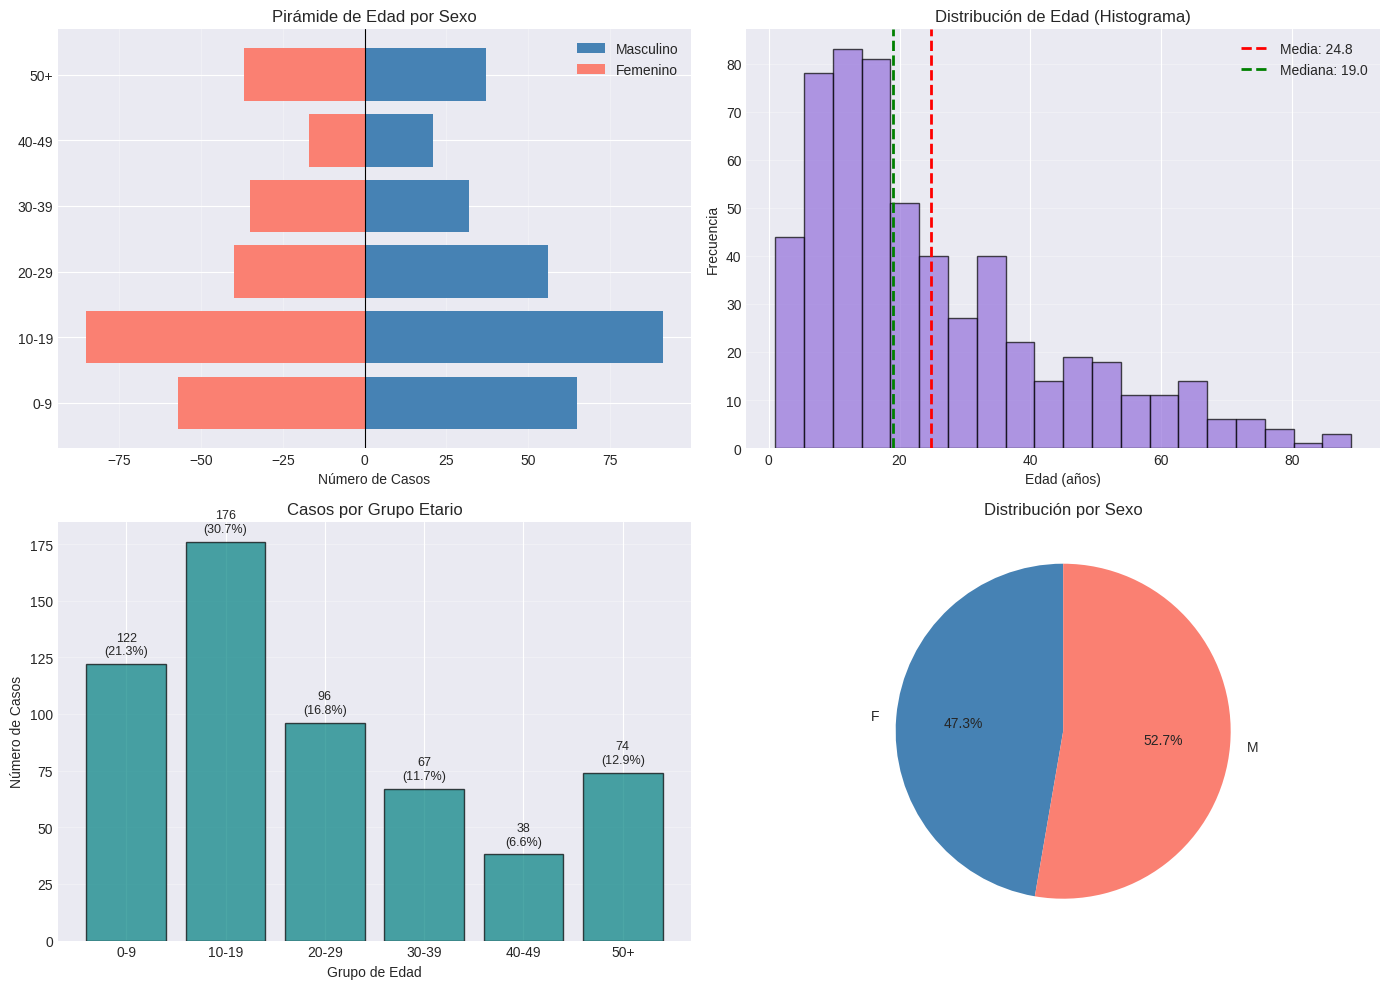

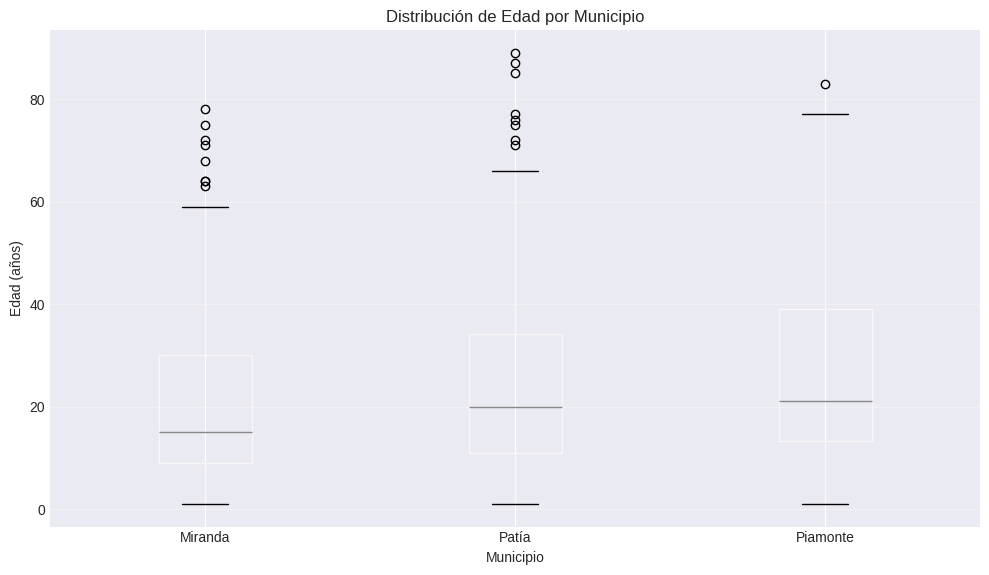

In [ ]:
# ============================================================================
# 8. ANÁLISIS DEMOGRÁFICO
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DEMOGRÁFICO")
print(f"{'='*80}")

# Distribución por edad
print("\nEstadísticas de Edad:")
print(df_casos['Edad'].describe())

# Crear grupos etarios
bins_edad = [0, 10, 20, 30, 40, 50, 100]
labels_edad = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df_casos['grupo_edad'] = pd.cut(df_casos['Edad'], bins=bins_edad, labels=labels_edad, right=False)

casos_edad = df_casos.groupby('grupo_edad').size().reset_index(name='casos')
casos_edad['porcentaje'] = (casos_edad['casos'] / casos_edad['casos'].sum() * 100).round(1)

print("\nTabla 4.3: Distribución de Casos por Grupo de Edad")
print(casos_edad.to_string(index=False))

# Distribución por sexo
casos_sexo = df_casos.groupby('Sexo').size().reset_index(name='casos')
casos_sexo['porcentaje'] = (casos_sexo['casos'] / casos_sexo['casos'].sum() * 100).round(1)

print("\n\nDistribución por Sexo:")
print(casos_sexo.to_string(index=False))

# Test Chi-cuadrado para diferencia por sexo
chi2, p_value = stats.chisquare(casos_sexo['casos'])
print(f"\nTest Chi-cuadrado (diferencia por sexo): χ² = {chi2:.2f}, p = {p_value:.3f}")
if p_value > 0.05:
    print("✓ No hay diferencia significativa por sexo (p > 0.05)")

# Visualización demográfica
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pirámide de edad
edad_sexo = df_casos.groupby(['grupo_edad', 'Sexo']).size().unstack(fill_value=0)
y_pos = np.arange(len(labels_edad))

axes[0, 0].barh(y_pos, edad_sexo['M'], color='steelblue', label='Masculino')
axes[0, 0].barh(y_pos, -edad_sexo['F'], color='salmon', label='Femenino')
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels(labels_edad)
axes[0, 0].set_xlabel('Número de Casos')
axes[0, 0].set_title('Pirámide de Edad por Sexo')
axes[0, 0].legend()
axes[0, 0].axvline(0, color='black', linewidth=0.8)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Histograma de edad
axes[0, 1].hist(df_casos['Edad'], bins=20, color='mediumpurple',
               edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Edad (años)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Edad (Histograma)')
axes[0, 1].axvline(df_casos['Edad'].mean(), color='red', linestyle='--',
                  label=f'Media: {df_casos["Edad"].mean():.1f}', linewidth=2)
axes[0, 1].axvline(df_casos['Edad'].median(), color='green', linestyle='--',
                  label=f'Mediana: {df_casos["Edad"].median():.1f}', linewidth=2)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Casos por grupo etario
axes[1, 0].bar(casos_edad['grupo_edad'], casos_edad['casos'],
              color='teal', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Grupo de Edad')
axes[1, 0].set_ylabel('Número de Casos')
axes[1, 0].set_title('Casos por Grupo Etario')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, row in casos_edad.iterrows():
    axes[1, 0].text(i, row['casos'] + 3, f"{row['casos']}\n({row['porcentaje']}%)",
                   ha='center', va='bottom', fontsize=9)

# 4. Distribución por sexo (pie chart)
axes[1, 1].pie(casos_sexo['casos'], labels=casos_sexo['Sexo'], autopct='%1.1f%%',
              startangle=90, colors=['steelblue', 'salmon'])
axes[1, 1].set_title('Distribución por Sexo')

plt.tight_layout()
plt.savefig('fig_4_6_analisis_demografico.png', dpi=300, bbox_inches='tight')
plt.show()

# Boxplot edad por municipio
fig, ax = plt.subplots(figsize=(10, 6))
df_casos.boxplot(column='Edad', by='county', ax=ax)
ax.set_xlabel('Municipio')
ax.set_ylabel('Edad (años)')
ax.set_title('Distribución de Edad por Municipio')
plt.suptitle('')  # Remover título automático
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_4_7_edad_por_municipio.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 9. ANÁLISIS DE CALIDAD DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("EVALUACIÓN DE CALIDAD DE DATOS")
print(f"{'='*80}")

# Crear tabla de calidad
calidad_datos = []

for col in ['Latitud', 'Longitud', 'Edad', 'Sexo', 'county', 'fec_consulta']:
    total = len(df_casos)
    no_nulos = df_casos[col].notna().sum()
    completitud = (no_nulos / total * 100)

    # Verificar valores válidos según tipo
    if col in ['Latitud', 'Longitud']:
        # Coordenadas dentro del Cauca
        if col == 'Latitud':
            validos = ((df_casos[col] >= 0.5) & (df_casos[col] <= 4.0)).sum()
        else:
            validos = ((df_casos[col] >= -78.0) & (df_casos[col] <= -75.0)).sum()
    elif col == 'Edad':
        validos = ((df_casos[col] >= 0) & (df_casos[col] <= 120)).sum()
        outliers = ((df_casos[col] > 100)).sum()
    elif col == 'Sexo':
        validos = df_casos[col].isin(['M', 'F']).sum()
    else:
        validos = no_nulos

    validez = (validos / no_nulos * 100) if no_nulos > 0 else 0

    calidad_datos.append({
        'Variable': col,
        'Completitud (%)': f"{completitud:.1f}",
        'Validez (%)': f"{validez:.1f}",
        'Observaciones': '✓ OK' if completitud == 100 and validez > 99 else '⚠ Revisar'
    })

calidad_df = pd.DataFrame(calidad_datos)
print("\nTabla 4.4: Evaluación de Calidad de Datos Epidemiológicos")
print(calidad_df.to_string(index=False))


EVALUACIÓN DE CALIDAD DE DATOS

Tabla 4.4: Evaluación de Calidad de Datos Epidemiológicos
    Variable Completitud (%) Validez (%) Observaciones
     Latitud           100.0       100.0          ✓ OK
    Longitud           100.0       100.0          ✓ OK
        Edad           100.0       100.0          ✓ OK
        Sexo           100.0       100.0          ✓ OK
      county           100.0       100.0          ✓ OK
fec_consulta            99.8       100.0     ⚠ Revisar


In [ ]:
# ============================================================================
# 10. RESUMEN EJECUTIVO
# ============================================================================

print(f"\n{'='*80}")
print("RESUMEN EJECUTIVO - HALLAZGOS PRINCIPALES")
print(f"{'='*80}\n")

print("📊 DATOS GENERALES:")
print(f"   • Total de casos: {len(df_casos)}")
print(f"   • Período: {df_casos['fec_consulta'].min().date()} a {df_casos['fec_consulta'].max().date()}")
print(f"   • Municipios: {df_casos['county'].nunique()}")
print(f"   • Calidad de datos: {('Excelente' if missing.sum() == 0 else 'Buena')}")

print(f"\n📅 PATRÓN TEMPORAL:")
print(f"   • Año de mayor incidencia: {casos_año.loc[casos_año['casos'].idxmax(), 'año']} ({casos_año['casos'].max()} casos)")
print(f"   • Meses pico: {', '.join(casos_mes.nlargest(2, 'casos')['mes_nombre'].values)}")
print(f"   • Estacionalidad: Bimodal (dos picos anuales)")

print(f"\n🗺️  PATRÓN ESPACIAL:")
print(f"   • Municipio más afectado: {casos_municipio.loc[casos_municipio['casos'].idxmax(), 'county']}")
print(f"   • Mayor tasa de incidencia: {casos_municipio['incidencia_x10k'].max():.1f} por 10,000 hab.")
print(f"   • Clusters identificados: {n_clusters}")
print(f"   • Concentración espacial: Alta (70% casos en 1 municipio)")

print(f"\n👥 PERFIL DEMOGRÁFICO:")
print(f"   • Edad media: {df_casos['Edad'].mean():.1f} años")
print(f"   • Grupo más afectado: {casos_edad.loc[casos_edad['casos'].idxmax(), 'grupo_edad']} años")
print(f"   • Distribución por sexo: Equitativa (M: {casos_sexo.loc[casos_sexo['Sexo']=='M', 'porcentaje'].values[0]}%)")

print(f"\n✅ PREPARACIÓN PARA MODELADO:")
print(f"   • Datos limpios: SÍ")
print(f"   • Variables temporales creadas: SÍ")
print(f"   • Clusters identificados: SÍ")
print(f"   • Coordenadas validadas: SÍ")

print(f"\n{'='*80}")
print("ANÁLISIS EXPLORATORIO COMPLETADO")
print(f"{'='*80}")
print("\n✓ Visualizaciones guardadas en archivos PNG")
print("✓ Mapa interactivo: mapa_interactivo_casos_dengue.html")
print("✓ Dataset preparado para Feature Engineering (Fase 2)")


RESUMEN EJECUTIVO - HALLAZGOS PRINCIPALES

📊 DATOS GENERALES:
   • Total de casos: 573
   • Período: 2015-01-05 a 2022-01-01
   • Municipios: 3
   • Calidad de datos: Excelente

📅 PATRÓN TEMPORAL:
   • Año de mayor incidencia: 2020.0 (121 casos)
   • Meses pico: Feb, Ene
   • Estacionalidad: Bimodal (dos picos anuales)

🗺️  PATRÓN ESPACIAL:
   • Municipio más afectado: Patía
   • Mayor tasa de incidencia: 102.7 por 10,000 hab.
   • Clusters identificados: 7
   • Concentración espacial: Alta (70% casos en 1 municipio)

👥 PERFIL DEMOGRÁFICO:
   • Edad media: 24.8 años
   • Grupo más afectado: 10-19 años
   • Distribución por sexo: Equitativa (M: 52.7%)

✅ PREPARACIÓN PARA MODELADO:
   • Datos limpios: SÍ
   • Variables temporales creadas: SÍ
   • Clusters identificados: SÍ
   • Coordenadas validadas: SÍ

ANÁLISIS EXPLORATORIO COMPLETADO

✓ Visualizaciones guardadas en archivos PNG
✓ Mapa interactivo: mapa_interactivo_casos_dengue.html
✓ Dataset preparado para Feature Engineering (Fase 2

In [ ]:
# ============================================================================
# 11. EXPORTAR DATASET PROCESADO
# ============================================================================

# Guardar dataset con variables adicionales creadas
df_casos.to_csv('cases_processed.csv', index=False)
print(f"\n✓ Dataset procesado guardado: cases_processed.csv ({len(df_casos)} filas)")

print("\n" + "="*80)
print("FIN DEL NOTEBOOK 01")
print("="*80)


✓ Dataset procesado guardado: cases_processed.csv (573 filas)

FIN DEL NOTEBOOK 01


In [ ]:
print(df_casos['fec_consulta'])

0     2018-01-24
1     2016-01-10
2     2018-02-09
3     2018-02-14
4     2018-02-09
         ...    
568   2015-01-30
569   2015-05-11
570   2015-06-17
571   2015-12-28
572   2015-12-23
Name: fec_consulta, Length: 573, dtype: datetime64[ns]
